In [2]:
'''
torch的梯度计算机制有点难以理解.
no_grad与detach有异曲同工之妙，都是逃避autograd的追踪.
'''
import torch
from torch.autograd import Variable
x = Variable(torch.ones(1, 2),requires_grad=True)
print(id(x))
print('x初始值：',x)
##如果不使用no_grad，会报错
with torch.no_grad():
    x += 1 #或者调用x.add_(1) #注意add_下划线
x,print(id(x))##原地加法，x的id没变。

2531106437568
x初始值： tensor([[1., 1.]], requires_grad=True)
2531106437568


(tensor([[2., 2.]], requires_grad=True), None)

## AUTOGRAD机制

本笔记将介绍自动grad如何工作和记录操作的概述。理解这一切并不是完全必要的，但我们建议您熟悉它，因为它将帮助您编写更高效、更清晰的程序，并可以帮助您进行调试。

### 自动grad如何编码历史

Autograd是一种反向自动微分系统。从概念上讲，autograd会记录一个图，记录所有在你执行操作时创建数据的操作，给你一个有向无环图，它的叶子是输入张量，根是输出张量。通过跟踪这个从根到叶的图，您可以使用链式法则自动计算梯度。
在内部，autograd将这个图表示为函数对象(实际上是表达式)的图，可以使用apply()来计算图的评估结果。当计算正向传递时，autograd同时执行请求的计算，并构建一个表示计算梯度的函数的图(每个torch.Tensor的.grad_fn属性是图的入口点)。当向前传递完成时，我们在向后传递（backwards）中评估这个图来计算梯度。

需要注意的重要一点是，图在每次迭代时都是从头重新创建的，这正是允许使用任意Python控制流语句的原因，这些语句可以在每次迭代时更改图的整体形状和大小。在开始训练之前，您不必对所有可能的路径进行编码——您所运行的是您所区分的。

#### 保存张量
有些操作需要在前向传递过程中保存中间结果，以便执行后向传递。例如，函数${x\mapsto x^2}$
保存输入x来计算梯度。
在定义自定义Python函数时，可以使用save_for_backward()在向前传递时保存张量，在向后传递时使用saved_tensors检索张量。更多信息请参见扩展PyTorch。
对于PyTorch定义的操作(例如torch.pow())，张量会根据需要自动保存。通过查找以_saved前缀开头的某个grad_fn属性，可以探索(出于教育或调试目的)哪些张量是由某个grad_fn保存的。

In [2]:
x = torch.randn(5, requires_grad=True)
y = x.pow(2)
print(x.equal(y.grad_fn._saved_self))  # True
print(x is y.grad_fn._saved_self)  # True

True
True


在前面的代码中，y.grad_fn。_saved_self与x指向同一个张量对象。但情况并非总是如此。例如:

In [3]:
x = torch.randn(5, requires_grad=True)
y = x.exp()
print(y.equal(y.grad_fn._saved_result))  # True
print(y is y.grad_fn._saved_result)  # False

True
False


在内部，为了防止引用循环，PyTorch在保存时打包了该张量，并将其解包到另一个张量中以供读取。
这里是通过访问y.grad_fn获得的张量。_saved_result是一个与y不同的张量对象(但它们仍然共享相同的存储)。

一个张量是否会被打包到一个不同的张量对象中，取决于它是否是它自己的grad_fn的输出，
这是一个实现细节，可能会发生变化，用户不应该依赖于它。
你可以用钩子控制PyTorch如何打包/解压保存的张量。


#### 不可微函数的梯度
只有当所使用的每个初等函数都是可微的时，使用自动微分的梯度计算才有效。不幸的是，我们在实践中使用的许多函数都没有这个属性(例如relu或sqrt at 0)。尽管我们不能总是保证返回的梯度是正确的。例如，${f(x)=x= \text{relu}(x) - \text{relu}(-x)}$将在0处给出0梯度而不是1，我们为relu在0处的梯度选择任何值。为了尽量减少这种限制的影响，我们按顺序应用以下规则来定义基本操作的梯度:
如果函数是可微的，因此在当前点存在梯度，使用它。
如果函数是凸的(至少在局部)，使用最小范数的次梯度(因为它是最陡下降方向，参见练习2.7 Bertsekas, D. P的“凸优化算法”和Bertsekas, D. P和Mitter, S. K.， 1971年的“具有不可微代价泛函的优化问题的最陡下降”。详情及校样)。
如果函数是凹的(至少在局部)，使用最小范数的超梯度(使用与上面类似的参数)。
如果定义了函数，则通过连续性定义当前点的梯度(注意这里可以使用infinf，例如sqrt(0)sqrt(0))。如果可能有多个值，则任意选择一个。
如果函数未定义${\sqrt{(-1)}−1)}$，${\log(-1)}$或大多数函数，例如，当输入是nan时)，那么用作梯度的值是任意的(我们也可能会引发错误，但不保证)。大多数函数将使用楠楠作为梯度，但出于性能原因，一些函数将使用非None值(例如${\log(-1)log(−1))}$。

### 局部禁用梯度计算

Python中有几种机制可以在本地禁用梯度计算:
要在整个代码块中禁用梯度，可以使用无梯度模式和推理模式等上下文管理器。为了从梯度计算中更细粒度地排除子图，可以设置张量的requires_grad字段。
下面，除了讨论上面的机制外，我们还描述了求值模式(nn.Module.eval())，这个方法实际上并不用于禁用梯度计算，但由于它的名字，它经常与这三种方法混在一起。

#### 设置requires_grad
Requires_grad是一个标志，默认为false，除非包装在nn.Parameter中，该参数允许从梯度计算中细粒度地排除子图。它在向前和向后传递中都起作用:
在正向传递过程中，只有当一个操作的输入张量中至少有一个需要梯度时，该操作才会记录在反向图中。在向后传递(.backward())期间，只有requires_grad=True的叶张量才会有梯度积累到它们的.grad字段中。
重要的是要注意，即使每个张量都有这个标志，设置它只对叶张量有意义(没有grad_fn的张量，例如nn。模块的参数)。非叶张量(具有grad_fn的张量)是具有反向图的张量。因此，它们的梯度将需要作为中介结果来计算需要梯度的叶张量的梯度。从这个定义可以清楚地看出，所有的非叶张量都将自动具有require_grad=True。
设置requires_grad应该是您控制模型的哪些部分是梯度计算的一部分的主要方法，例如，如果您需要在模型微调期间冻结预训练模型的部分。
要冻结模型的部分，只需对不需要更新的参数应用.requires_grad_(False)。如上所述，由于使用这些参数作为输入的计算不会被记录在向前传递中，它们不会在向后传递中更新它们的.grad字段，因为它们不会像期望的那样首先成为向后图形的一部分。
因为这是一种非常常见的模式，所以requires_grad也可以通过nn.Module.requires_grad_()在模块级别设置。当应用于模块时，.requires_grad_()对模块的所有参数生效(requires_grad默认为True)。

#### 梯度模式
除了设置requires_grad之外，Python还启用了三种可能的模式，它们可以影响PyTorch中的计算如何由autograd内部处理:默认模式(grad模式)、无grad模式和推理模式，所有这些模式都可以通过上下文管理器和装饰器进行切换。
#### 默认模式(Grad模式)
“默认模式”实际上是我们在没有启用其他模式(如no-grad和推断模式)时隐式处于的模式。与“无梯度模式”相比，默认模式有时也被称为“梯度模式”。
关于默认模式，最重要的是要知道它是requires_grad生效的唯一模式。requires_grad在其他两种模式中总是被重写为False。

#### No-grad模式
无梯度模式下的计算就好像所有输入都不需要梯度。换句话说，即使有require_grad=True的输入，在无梯度模式下的计算也不会记录在反向图中。
当您需要执行不应该由自动grad记录的操作，但您仍然希望在grad模式下使用这些计算的输出时，启用无grad模式。这个上下文管理器可以方便地为一段代码或函数禁用梯度，而不必临时将张量设置为requires_grad=False，然后返回True。
例如，在编写优化器时，no-grad模式可能很有用:当执行培训更新时，您希望就地更新参数，而不需要autograd记录更新。您还打算在下一个向前传递中在梯度模式下使用更新的参数进行计算。
init中的实现在初始化参数时也依赖于no-grad模式，以避免在就地更新初始化参数时进行自动grad跟踪。

#### 推理模式
推理模式是无梯度模式的极端版本。就像在无梯度模式下一样，推理模式下的计算不会记录在向后图中，但启用推理模式将允许PyTorch进一步加速你的模型。这种更好的运行时有一个缺点:在推断模式中创建的张量将不能用于退出推断模式后由自grad记录的计算。
当您在执行不需要在向后图中记录的计算时，启用推断模式，并且您不打算在任何稍后将由autograd记录的计算中使用推断模式中创建的张量。
建议您在代码中不需要自动分级跟踪的部分(例如，数据处理和模型评估)尝试推断模式。如果它对您的用例来说是开箱即用的，那么它就是一个免费的性能胜利。如果在启用推理模式后遇到错误，请检查是否在退出推理模式后由自动grad记录的计算中使用推理模式中创建的张量。如果你不能避免这种使用在你的情况下，你可以总是切换回无grad模式。

#### 评估模式(nn.Module.eval ())
计算模式实际上不是一种局部禁用梯度计算的机制。这里包含它，因为它有时会被混淆为这样一种机制。
在功能上，module.eval()(或等效的module.train(False))与无梯度模式和推理模式完全正交。model.eval()如何影响模型完全取决于模型中使用的特定模块以及它们是否定义了任何特定于训练模式的行为。
如果你的模型依赖于像torch.nn. dropout和torch.nn这样的模块，你需要负责调用model.eval()和model.train()。BatchNorm2d可能会根据训练模式的不同表现不同，例如，避免更新验证数据上的BatchNorm运行统计信息。
建议您在训练时总是使用model.train()，在评估模型(验证/测试)时总是使用model.eval()，即使您不确定您的模型具有特定于训练模式的行为，因为您正在使用的模块可能会被更新以在训练和评估模式中表现不同。

#### 带有自动grad的就地操作
在autograd中支持就地操作是一件困难的事情，我们不鼓励在大多数情况下使用它们。Autograd积极的缓冲区释放和重用使它非常高效，而且很少有就地操作显著降低内存使用量的情况。除非您在内存压力很大的情况下操作，否则您可能永远都不需要使用它们。
限制就地作业适用性的主要原因有两个:
就地操作可能会覆盖计算梯度所需的值。
实际上，每个就地操作都需要实现重写计算图。错位的版本只是分配新的对象并保留对旧图的引用，而就地操作则需要更改表示该操作的函数的所有输入的创建者。这可能是棘手的，特别是当有许多张量引用相同的存储(例如，通过索引或转置创建)，如果修改后的输入存储被任何其他张量引用，原位函数实际上会引发错误。

#### 就地正确性检查
每个张量都保留一个版本计数器，每次在任何操作中被标记为dirty时，该计数器就会递增。当一个函数向后保存任何张量时，包含它们的张量的版本计数器也会被保存。一旦你访问self。Saved_tensors它被检查，如果它大于保存的值将引发错误。这确保了如果您使用就地函数并且没有看到任何错误，您可以确保计算的梯度是正确的。

#### 多线程Autograd
autograd引擎负责运行计算向后传递所需的所有向后操作。本节将描述可以帮助您在多线程环境中充分利用它的所有细节。(这只与PyTorch 1.6+相关，因为之前版本的行为不同。)
用户可以用多线程代码训练他们的模型(例如Hogwild训练)，并且不阻塞并发的向后计算，示例代码可以是:

In [4]:
# Define a train function to be used in different threads
import threading
def train_fn():
    x = torch.ones(5, 5, requires_grad=True)
    # forward
    y = (x + 3) * (x + 4) * 0.5
    # backward
    y.sum().backward()
    # potential optimizer update


# User write their own threading code to drive the train_fn
threads = []
for _ in range(10):
    p = threading.Thread(target=train_fn, args=())
    p.start()
    threads.append(p)

for p in threads:
    p.join()

#### 并发性对CPU
当你通过python或c++ API在CPU上的多个线程中运行backward()或grad()时，你希望看到额外的并发性，而不是在执行期间按照特定的顺序序列化所有向后调用(在PyTorch 1.6之前的行为)。
#### 非确定性
如果你在多个线程上并发调用backward()，但是有共享的输入(例如Hogwild CPU训练)。由于参数是在线程间自动共享的，因此在跨线程的向后调用中，梯度累积可能变得不确定，因为两个向后调用可能访问并试图累积相同的.grad属性。这在技术上是不安全的，并可能导致比赛状况和结果可能无效使用。
但是，如果您使用多线程方法来驱动整个训练过程，但使用共享参数，这是预期的模式，使用多线程的用户应该记住线程模型，应该期望发生这种情况。用户可以使用函数API torch.autograd.grad()来计算梯度，而不是backward()来避免不确定性。
#### 图保留
如果autograd图的一部分在线程之间共享，即在前向单线程中运行第一部分，然后在多个线程中运行第二部分，那么图的第一部分是共享的。在这种情况下，在同一个图上执行grad()或backward()的不同线程可能会在一个线程运行时破坏图，而在这种情况下，另一个线程会崩溃。Autograd将错误输出给用户，类似于调用backward()两次而没有输出retain_graph=True，并让用户知道他们应该使用retain_graph=True。

#### Autograd节点上的线程安全
因为Autograd允许调用线程驱动向后执行以获得潜在的并行性，所以通过共享GraphTask的部分/全部向后并行来确保CPU上的线程安全是很重要的。
自定义Python autograd。由于GIL，函数是自动线程安全的。对于内置的c++ Autograd节点(例如:AccumulateGrad, copyyslices)和自定义Autograd::函数，Autograd引擎使用线程互斥锁来确保可能有读写状态的Autograd节点的线程安全。

-------------

### 求梯度的过程
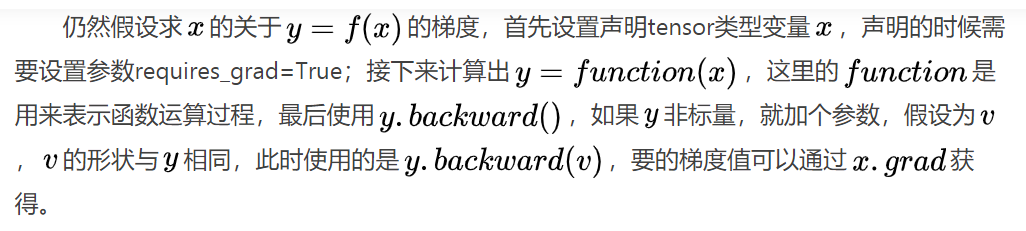

In [5]:
x=x+1
x,id(x)

(tensor([1.6608, 3.4878, 2.5317, 1.2168, 2.0211], grad_fn=<AddBackward0>),
 2199372664880)

In [6]:
from torch.autograd import Variable
import torch
x = Variable(torch.ones(1, 2),requires_grad=True)

y = x**2##可进行非原地计算，即将x进行计算后赋给一个新变量。
c = x+1 ##假如此处换为 x = x + 1,最后结果会输出什么？
z =  y**2
z.sum().backward()##z调用了backward了为什么还无梯度？那也是计算x的梯度
print(z.grad)  ## 输出：None#
print(y.grad)  ##输出：None
print(c.grad)  ##z,y,c都无梯度
##z=y**2=x**4,因此dz/dx=4*x**3,然后将(1,1)带入，那么x的梯度就是(4,4)了
print(x.grad)  ##输出：tensor([[4., 4.]])
print(x)  ##输出：tensor([[1., 1.]], requires_grad=True
print(y)  ##：tensor([[1., 1.]], grad_fn=<PowBackward0>
print(z)  ##:输出：tensor([[1., 1.]], grad_fn=<PowBackward0>)
print(c)  ##：输出：tensor([[2., 2.]], grad_fn=<AddBackward0>)


#x.grad.zero_()
c.sum().backward()
##很显然在c上的梯度是1，但是如果不对梯度清零，则会累加[4,4]+[1,1]，那么就是[5,5]
print(x.grad)

None
None
None
tensor([[4., 4.]])
tensor([[1., 1.]], requires_grad=True)
tensor([[1., 1.]], grad_fn=<PowBackward0>)
tensor([[1., 1.]], grad_fn=<PowBackward0>)
tensor([[2., 2.]], grad_fn=<AddBackward0>)
tensor([[5., 5.]])


C:\Users\hp\AppData\Local\Temp\ipykernel_21572\246170588.py:9: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten\src\ATen/core/TensorBody.h:491.)
  print(z.grad)  ## 输出：None#
C:\Users\hp\AppData\Local\Temp\ipykernel_21572\246170588.py:10: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf 

In [7]:
type(x),type(y)

(torch.Tensor, torch.Tensor)

In [8]:
'''
通过no_grad控制梯度的计算范围。
'''
from torch.autograd import Variable
import torch
x = Variable(torch.ones(1, 10),requires_grad=True)
y1 = (x)**2
y2 = (x)**2
z = y1**2 + y2**2##在y1和y2中的梯度都计算，然后相加。
z.sum().backward()
print(x.grad) ## 输出：tensor([[8., 8., 8., 8., 8., 8., 8., 8., 8., 8.]])
print(z) ##输出：tensor([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]], grad_fn=<AddBackward0>)

x = Variable(torch.ones(1, 10),requires_grad=True)
y1 = (x)**2
with torch.no_grad():
    y2 = (x)**2
z = y1**2 + y2**2
z.sum().backward() 
print(x.grad) ##输出：tensor([[4., 4., 4., 4., 4., 4., 4., 4., 4., 4.]])
print(z)##输出：tensor([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]], grad_fn=<AddBackward0>)

x = Variable(torch.ones(1, 10),requires_grad=True)
with torch.no_grad():
    x += 1
    y2 = (x)**2##放在no_grad上下文，不计算x在y2中的梯度
y1 = (x)**2
z = y1**2 + y2**2##z函数为：x**4+x**4
z.sum().backward()##梯度为：4*x**3（x在y2**2上的梯度不计算，只计算x在y1**2上的梯度，然后作为x在z上的梯度）
print(x.grad)##输出tensor([[32., 32., 32., 32., 32., 32., 32., 32., 32., 32.]])
print(z)##输出tensor([[32., 32., 32., 32., 32., 32., 32., 32., 32., 32.]],grad_fn=<AddBackward0>)

tensor([[8., 8., 8., 8., 8., 8., 8., 8., 8., 8.]])
tensor([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]], grad_fn=<AddBackward0>)
tensor([[4., 4., 4., 4., 4., 4., 4., 4., 4., 4.]])
tensor([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]], grad_fn=<AddBackward0>)
tensor([[32., 32., 32., 32., 32., 32., 32., 32., 32., 32.]])
tensor([[32., 32., 32., 32., 32., 32., 32., 32., 32., 32.]],
       grad_fn=<AddBackward0>)


In [9]:
'''
注意原地操作（更新tensor）之前不能用到相应tensor，如果用到，后面求梯度就不对之前用到的tensor进行求导。
这个例子是对前面那个例子的简单修改
'''
from torch.autograd import Variable
import torch
x = Variable(torch.ones(1, 10),requires_grad=True)
y1 = (x)**2##已经定义了y1
with torch.no_grad():
    x += 1#但是此处对x进行原地操作，那么y1就无法求梯度了
    y2 = (x)**2

z = y1**2 + y2**2
#print(x.requires_grad,x.is_leaf)
x.requires_grad_(True)
##这里会报错，报错内容见后面，因为在定义了y1之后，又对x进行原地操作
##因而对x求梯度，就会报错。
z.sum().backward() 
print(x.grad)
print(z)

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [1, 10]] is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [10]:
'''
多次求梯度，梯度会保存累加
'''
from torch.autograd import Variable
import torch
x = Variable(torch.ones(1, 2),requires_grad=True)
x.sum().backward()
print(x.grad)  #输出：tensor([[1., 1.]])
x.sum().backward()
print(x.grad)#输出：tensor([[2., 2.]])
x.sum().backward()
print(x.grad)#输出：tensor([[3., 3.]])

tensor([[1., 1.]])
tensor([[2., 2.]])
tensor([[3., 3.]])


In [11]:
x = Variable(torch.ones(1, 2),requires_grad=True)
x.sum().backward()
print(x.grad)  #输出：tensor([[1., 1.]])
x.grad.zero_()##上一次的梯度归零
x.sum().backward()
print(x.grad)#输出：tensor([[2., 2.]])
x.grad.zero_()##上一次的梯度归零
x.sum().backward()
print(x.grad)#输出：tensor([[3., 3.]])

tensor([[1., 1.]])
tensor([[1., 1.]])
tensor([[1., 1.]])


In [12]:
x.data=x.data+1

In [13]:
x.sum()

tensor(4., grad_fn=<SumBackward0>)

In [14]:
'''
一个变量有5个属性，要求这个变量可以求梯度，需要满足2个属性为真，
requires_grad=True，is_leaf=True。
在声明变量的时候声明requires_grad=True就可以了。
在实践过程中如果发现梯度没法计算，要查一下这两个属性。

'''
x.requires_grad,x.is_leaf

(True, True)

In [15]:
##z不是叶子tensor，所以不能计算梯度
z.requires_grad,z.is_leaf

(True, False)

In [16]:
'''
x 是一个（2,3）的矩阵，设置为可导，是叶节点，即leaf variable
y 也是一个（2,3）的矩阵，即
y=x2+x (x的平方加x)
实际上，就是要y的各个元素对相对应的x求导
'''
 
x = torch.tensor([[1.,2.,3.],[4.,5.,6.]],requires_grad=True)
y = torch.add(torch.pow(x,2),x)
print(y)
gradient=torch.tensor([[1.0,1.0,1.0],[1.0,1.0,1.0]])
 
y.backward(gradient)##2x+1
 
print('------------------\n',x.grad)
 


tensor([[ 2.,  6., 12.],
        [20., 30., 42.]], grad_fn=<AddBackward0>)
------------------
 tensor([[ 3.,  5.,  7.],
        [ 9., 11., 13.]])


In [17]:
##权重梯度下降
x = torch.tensor([1.,2.,3.],requires_grad=True)
y = torch.pow(x,2)
gradient=torch.tensor([1.0,0.1,0.001])
y.backward(gradient)
print(x.grad)

tensor([2.0000, 0.4000, 0.0060])


In [18]:
x = torch.tensor(5.0,requires_grad=True)
y = torch.pow(x,3)
 
grad_x = torch.autograd.grad(y, x, create_graph=True)
print(grad_x) # dy/dx = 3 * x2，即75
 
grad_grad_x = torch.autograd.grad(grad_x[0],x)
print(grad_grad_x) # 二阶导数 d(2x)/dx = 30
 

(tensor(75., grad_fn=<MulBackward0>),)
(tensor(30.),)


**************